### This file contains the code to compute the similarity metric between an original file and its variants. It is parametrized by whether the file should be read as instructions or bytes.

Some earier file has the code to compute similarity between variants and plot this against effectiveness to prevent attacks

In [1]:
from scipy.stats import spearmanr, stats
from scipy.spatial.distance import euclidean
from random import randint, shuffle,sample,random
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
path='/Users/fesponda/research/Diversity/Data/probNog_probBilr_randomized_2/'

ORIGINAL_FILE=path+'original'
TRANSFORMATION_INTENSITY_FILE='percent_bytes_moved'
OUTPUT_GRAPH='probNog_probBilr_randomized_2.pdf'

###Variable that controls if data is treated as bytes or instructions
BYTE_FILE=True
if BYTE_FILE:
    TRANSFORMS_DIR=path+'binaries/'
else:
    TRANSFORMS_DIR=path+'instructions/'


# Function Definitions

In [2]:
def read_instructions(file1):
    f=open(file1, 'r')
    P1=[]
    for line in f:
        P1.append(line.strip().replace(" ",""))
    return P1



In [3]:
def read_ELF(file1):
    with open(file1, 'rb') as f:
        P1=list(f.read())
    return P1



In [4]:
#P1=read_instructions(ORIGINAL_FILE)


In [5]:
def read_instructions_only_inst(file1):
    f=open(file1, 'r')
    P1=[]
    for line in f:
        P1.append(line.split()[0])
    return P1


In [6]:
def read_file(file1,BYTE_FILE):
    if BYTE_FILE: 
        return read_ELF(file1)
    else:
        return read_instructions(file1)

In [7]:
##Create dictionary. For each byte in the block we create unique entry. If a byte is repeated we append if its the first, second, etc occurrence
def P1_dictionary(P1):
    P1_dict={}
    P1_occ={}
    for index,byte in enumerate(P1):   
        if byte  in P1_occ.keys():
            P1_occ[byte]+=1
        else:
            P1_occ[byte]=1
        value=str(byte)+'_'+str(P1_occ[byte]) ## here we create a unique value for each byte in the section
        P1_dict[value]=index+1 #we start to count at 1
    return P1_dict

In [8]:
####Rank instructions of a block according to first file template
def rank_P2(P1_dict,P2,intersection=False):
    a=[]        
    b=[]
    med_rank=len(P1_dict.keys())/2.0
    P2_dict={}
    P2_occ={}
    for index,byte in enumerate(P2):   
        if byte  in P2_occ.keys():
            P2_occ[byte]+=1
        else:
            P2_occ[byte]=1
        value=str(byte)+'_'+str(P2_occ[byte]) ## here we create a unique value for each byte in the section
        if value in P1_dict.keys():
            P2_dict[value]=P1_dict[value]
            a.append(index+1)
            b.append(P2_dict[value])
        elif not intersection:
            P2_dict[value]=0 ###zero for no existent value....check Maybe not bother, Maybe random, maybe average
            P2_dict[value]=med_rank 
            #P2_dict[value]=randint(1,90)
            a.append(index+1)
            b.append(P2_dict[value])
            
    #print(len(a),len(b))
    return a,b



# Execution

In [31]:
# Get list of files
l = [f for f in listdir(TRANSFORMS_DIR) if isfile(join(TRANSFORMS_DIR, f)) and f[0]!='.']

# Using other metrics

In [32]:
from scipy.spatial import distance

In [33]:
def hamm(P1,P2):
    if len(P1) != len(P2):
        print('Length mismatch')
        return -1
    matches=0
    for i in range(len(P1)):
        if P1[i]==P2[i]:
            matches+=1
    return matches/len(P1)

In [34]:
# We will need to pad, for now with zeroes or 64's
def pad(P1,P2, value=0):
    if (len(P1)> len(P2)):
        P2+=[value for i in range(len(P1)-len(P2)) ]
    else:
        P1+=[value for i in range(len(P2)-len(P1)) ]
    return P1,P2


In [35]:
# Compute similarity between original and each transform
P1=read_file(ORIGINAL_FILE,BYTE_FILE)
#P1_dict=P1_dictionary(P1)
result=[]
p=0
for knob in l:
    P2=read_file(TRANSFORMS_DIR+knob,BYTE_FILE)
    P1,P2=pad(P1,P2,value=6400)
    #dist=euclidean(P1,P2)
    dist=hamm(P1,P2)
    #a,b=rank_P2(P1_dict,P2,intersection=True)
    #corr,p=spearmanr(a,b)
    result.append((knob,dist,p))
#print(result)

In [36]:
# Compute similarity between original and each transform
############################################Chunk version
'''
CHUNK_PERC=0.3
P1=read_file(ORIGINAL_FILE,BYTE_FILE)
chunk_size=int(CHUNK_PERC*len(P1)+1)


    
result=[]
for knob in l:

    suma=0
    i=0
    P2=read_file(TRANSFORMS_DIR+knob,BYTE_FILE)
    chunk_size2=int(CHUNK_PERC*len(P2)+1)
    used_chunks=[]
    for c_size in range(0,len(P1),chunk_size):
        P1_dict=P1_dictionary(P1[c_size:c_size+chunk_size])
        max_sim=0
        p=1
        current_chunk=-1
        for c_size2 in range(0,len(P2),chunk_size2):
            if c_size in used_chunks:
                continue
            a,b=rank_P2(P1_dict,P2[c_size2:c_size2+chunk_size2],intersection=True)
            corr,p=spearmanr(a,b)
            #print(corr)
            if corr > max_sim: 
                current_chunk=c_size2
                max_sim=corr
                p=p  
        #print('out')
        used_chunks.append(current_chunk)
        suma=suma+max_sim
        i+=1
        
    result.append((knob,suma/i,'nada'))
    
#print(result)
'''

"\nCHUNK_PERC=0.3\nP1=read_file(ORIGINAL_FILE,BYTE_FILE)\nchunk_size=int(CHUNK_PERC*len(P1)+1)\n\n\n    \nresult=[]\nfor knob in l:\n\n    suma=0\n    i=0\n    P2=read_file(TRANSFORMS_DIR+knob,BYTE_FILE)\n    chunk_size2=int(CHUNK_PERC*len(P2)+1)\n    used_chunks=[]\n    for c_size in range(0,len(P1),chunk_size):\n        P1_dict=P1_dictionary(P1[c_size:c_size+chunk_size])\n        max_sim=0\n        p=1\n        current_chunk=-1\n        for c_size2 in range(0,len(P2),chunk_size2):\n            if c_size in used_chunks:\n                continue\n            a,b=rank_P2(P1_dict,P2[c_size2:c_size2+chunk_size2],intersection=True)\n            corr,p=spearmanr(a,b)\n            #print(corr)\n            if corr > max_sim: \n                current_chunk=c_size2\n                max_sim=corr\n                p=p  \n        #print('out')\n        used_chunks.append(current_chunk)\n        suma=suma+max_sim\n        i+=1\n        \n    result.append((knob,suma/i,'nada'))\n    \n#print(resul

In [37]:
# Pair up the similarity with the intensity of the transform. This is very specific to the current file 
# formats. The intensity file has a fragment of the transforms file name and the intensity comma separated

result=sorted(result,key=lambda x: x[0])
with open(path+TRANSFORMATION_INTENSITY_FILE) as fp:
    lines=fp.readlines()

perc_moved=[]
for line in lines:
    l=line.rstrip().split(',')
    perc_moved.append((l[0],float(l[1])))
perc_moved=sorted(perc_moved,key=lambda x: x[0])
###check could of sorted but I rather check

simi=[]
move=[]

for sim in result:
    for perc in perc_moved:
        if perc[0] in sim[0]:
            print (perc[0], sim[0],sim[1],perc[1])
            simi.append(sim[1])
            move.append(perc[1])
            break
final=zip(result,perc_moved)

1000_0 httpd-1000_0 0.1462306910635446 25.9
1000_1 httpd-1000_1 0.14618978299138102 25.9
1000_2 httpd-1000_2 0.15161837120593952 22.8
1100_0 httpd-1100_0 0.14547215095949012 25.9
1100_1 httpd-1100_1 0.1452027669523704 25.9
1100_2 httpd-1100_2 0.18620527583573232 16.2
1200_0 httpd-1200_0 0.1925316656766043 10.4
1200_1 httpd-1200_1 0.15982827313536438 20.9
1200_2 httpd-1200_2 0.15925425454830308 13.8
1300_0 httpd-1300_0 0.15749738340655442 23.5
1300_1 httpd-1300_1 0.15601816492480966 26.6
1300_2 httpd-1300_2 0.15595506204753606 26.6
1400_0 httpd-1400_0 0.15581449494850588 17.2
1400_1 httpd-1400_1 0.17118766142912786 14.5
1400_2 httpd-1400_2 0.16923669454073073 14.5
1500_0 httpd-1500_0 0.14645307430690194 25.4
1500_1 httpd-1500_1 0.15115228029862893 21.5
1500_2 httpd-1500_2 0.13908265824134458 32.7
1600_0 httpd-1600_0 0.15643066869693767 14.1
1600_1 httpd-1600_1 0.15870112518958063 14.1
1600_2 httpd-1600_2 0.15539758076624302 22.2
1700_0 httpd-1700_0 0.1338316284676663 32.7
1700_1 httpd-1

In [38]:
print(len(move),len(simi))

48 48


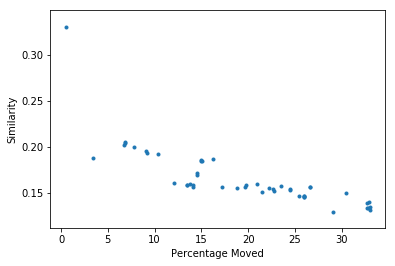

In [39]:
plt.scatter(move,simi,marker='.')
plt.ylabel('Similarity')
plt.xlabel('Percentage Moved')
#plt.ylim([0.75, 1])
plt.savefig(OUTPUT_GRAPH)

In [17]:
s=zip(move,simi)
list(s)

[(25.9, 153492.72289265052),
 (25.9, 153696.48576333813),
 (22.8, 151448.3061212637),
 (25.9, 153305.50465329026),
 (25.9, 153277.72289540316),
 (16.2, 147548.73821554694),
 (10.4, 145570.4017477454),
 (20.9, 150670.6427244538),
 (13.8, 149312.34628790748),
 (23.5, 150781.4408208119),
 (26.6, 152948.91564506106),
 (26.6, 152825.51735884947),
 (17.2, 149903.52430813626),
 (14.5, 148283.59380592313),
 (14.5, 148482.30533972726),
 (25.4, 152605.23798022137),
 (21.5, 151088.1599265806),
 (32.7, 156495.5213608364),
 (14.1, 149260.56782687115),
 (14.1, 149180.28883200354),
 (22.2, 150596.20625035677),
 (32.7, 156942.35690214418),
 (24.5, 151227.99106977516),
 (24.5, 151479.11457689473),
 (32.9, 156435.77850670862),
 (32.8, 156196.79073527726),
 (12.1, 148468.1174292986),
 (22.6, 150458.71487222),
 (13.5, 149013.71498623877),
 (13.5, 148873.03925157167),
 (33.0, 156856.86533269752),
 (30.4, 154166.57644249612),
 (33.0, 156718.45759514096),
 (6.8, 144888.05534618787),
 (6.8, 144895.49559596393

In [18]:
print(len(set(P1).intersection(set(P2))),len(set(P1)),len(set(P2)))

256 256 256


In [19]:
print(len(P2),len(set(P2)),len(set(P2))/len(P2))

2297887 256 0.00011140669667394436


In [ ]:
##read results

In [59]:
def read_pov_results(path,transform,result_file='results.txt'):
    #with open('/Users/fesponda/research/Diversity/Data/transforms_to_compare/structNoc/results.txt') as fp:
    result={}
    with open(path+'/'+transform+'/'+result_file) as fp:
        lines=fp.readlines()
    for line in lines:
        if line.find('Still vulnerable')>=0:
            total=int(line.split()[5])
            num=float(line.split()[3])
            result['Still vulnerable']=(total-num)/total
        if line.find('Showed Divergence')>=0:
            total=int(line.split()[5])
            num=float(line.split()[3])
            result['Showed Divergence']=num/total
    return (result)

          

In [60]:
read_pov_results('/Users/fesponda/research/Diversity/Data/transforms_to_compare','structNoc')

{'Showed Divergence': 0.2857142857142857,
 'Still vulnerable': 0.5476190476190477}

In [63]:
transforms=[
'2probBilr_probP1_probNos_probNol_probNoh_zipr+1structNoc_structP1Canaries_structNos_structNol_structNoh_zipr',
'2structNogOF_phase1_zipr+1probNog_phase1_zipr',
'2structNogOF_structSS_phase1_zipr+1probNog_probSS_phase1_zipr',
'probBilr',
'structNoc',
'structNoc_structP1Canaries',
'structP1Canaries',
'probNog_probBilr']


pov_results={}
for transform in transforms:
    pov_results[transform]=read_pov_results('/Users/fesponda/research/Diversity/Data/transforms_to_compare',transform)

In [64]:
pov_results

{'2probBilr_probP1_probNos_probNol_probNoh_zipr+1structNoc_structP1Canaries_structNos_structNol_structNoh_zipr': {'Showed Divergence': 0.2619047619047619,
  'Still vulnerable': 0.5714285714285714},
 '2structNogOF_phase1_zipr+1probNog_phase1_zipr': {'Showed Divergence': 0.2857142857142857,
  'Still vulnerable': 0.7619047619047619},
 '2structNogOF_structSS_phase1_zipr+1probNog_probSS_phase1_zipr': {'Showed Divergence': 0.2619047619047619,
  'Still vulnerable': 0.7619047619047619},
 'probBilr': {'Showed Divergence': 0.23809523809523808,
  'Still vulnerable': 0.5476190476190477},
 'structNoc': {'Showed Divergence': 0.2857142857142857,
  'Still vulnerable': 0.5476190476190477},
 'structNoc_structP1Canaries': {'Showed Divergence': 0.2857142857142857,
  'Still vulnerable': 0.5714285714285714},
 'structP1Canaries': {'Showed Divergence': 0.23809523809523808,
  'Still vulnerable': 0.5476190476190477},
 'probNog_probBilr': {'Showed Divergence': 0.23809523809523808,
  'Still vulnerable': 0.5476190